In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

import time
import numpy as np
import torch

from vqa import simulate_pqc_and_get_gradient, optimize_pqc_gradient
from palqo import ParameterPredictorNet, train_neural_network


In [ ]:

# Define device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# PQC parameter list
qubit_epoch_list = (20, 3, -1, 2)
(
    num_qubits,
    pqc_depth,
    ising_j_coupling,
    ising_b_field_coeff,
) = qubit_epoch_list

# Ising Hamiltonian parameters
ISING_J = ising_j_coupling * 4
ISING_BX = -1 * ising_j_coupling / ising_b_field_coeff * 2


# VQE optimizer parameters
VQE_LEARNING_RATE = 0.01
VQE_MAX_ITER = 20
VQE_INIT_SEED = 2025

# Net (neural network) training parameters
NET_SEED = 2025
NET_HIDDEN_DIM = 50 * 2 * num_qubits * pqc_depth
NET_LEARNING_RATE = 1e-4
NET_WEIGHT_DECAY = 0.00001
NET_LOSS_THRESHOLD = 5e-6
NET_NUM_EPOCH = 3000

# PALQO iteration parameters
PALQO_SAMPLE = 2
PALQO_MAX_ITER = VQE_MAX_ITER - PALQO_SAMPLE
PALQO_PRE_NUM = 2000

# Initialize PQC model
fun_pqc, num_pqc_params = simulate_pqc_and_get_gradient(num_qubits, pqc_depth, ISING_J, ISING_BX)
print("JAX compiling...")
fun_pqc(VQE_INIT_SEED)  # First call triggers JAX compilation
print("JAX compiled.")

# Initialize neural network
set_seed = lambda seed: None  # Dummy set_seed function as it's in palqo.py
set_seed(NET_SEED)
net = ParameterPredictorNet(num_pqc_params + 1, NET_HIDDEN_DIM, num_pqc_params + 1).to(device)
optimizer_net = torch.optim.Adam(net.parameters(), lr=NET_LEARNING_RATE, weight_decay=NET_WEIGHT_DECAY)


In [ ]:
# VQE baseline experiment
print("-" * 20 + "VQE-baseline" + "-" * 20)
np.random.seed(VQE_INIT_SEED)
initial_pqc_params = np.random.uniform(0, 1, num_pqc_params)
optimal_pqc_params_vqe, vqe_energy_history = optimize_pqc_gradient(
    initial_pqc_params, VQE_LEARNING_RATE, VQE_MAX_ITER, fun_pqc
)
print("The VQE energy list is", vqe_energy_history)
print("-" * 20 + "VQE-baseline Finished" + "-" * 20)

In [4]:
# Initialize neural network
set_seed = lambda seed: None  # Dummy set_seed function as it's in palqo.py
set_seed(NET_SEED)
net = ParameterPredictorNet(num_pqc_params + 1, NET_HIDDEN_DIM, num_pqc_params + 1).to(device)
optimizer_net = torch.optim.Adam(net.parameters(), lr=NET_LEARNING_RATE, weight_decay=NET_WEIGHT_DECAY)


In [5]:
# PALQO iteration start
print("-" * 20 + "PALQO Iteration Start" + "-" * 20)

theta_list_op_temp = initial_pqc_params.tolist().copy()
iter_pinn = 0
PALQO_energy_list = []
PALQO_energy_list.extend(vqe_energy_history[:PALQO_SAMPLE])
num_train_data = PALQO_SAMPLE
repeat = False
f_list_temp = vqe_energy_history[:PALQO_SAMPLE].copy()

for iter in range(PALQO_MAX_ITER):
    print("-" * 20 + f"PALQO Iteration -{iter}" + "-" * 20)
    theta_list_op, temp_min_value = train_neural_network(
        net,
        optimizer_net,
        num_train_data,
        iter_pinn,
        VQE_LEARNING_RATE,
        NET_NUM_EPOCH,
        NET_LOSS_THRESHOLD,
        PALQO_SAMPLE,
        fun_pqc,
        PALQO_PRE_NUM,
    )
   
    if temp_min_value < f_list_temp[-1]:
        initial_pqc_params = theta_list_op
        iter_pinn += 1
        if iter >= 1:
            PALQO_energy_list.extend(f_list_temp[:num_train_data])
        num_train_data = PALQO_SAMPLE
        theta_list_op_temp = theta_list_op.copy()
        repeat = False
    else:
        initial_pqc_params = theta_list_op_temp
        num_train_data = int(num_train_data + 1)
        repeat = True
    if not repeat and (iter_pinn + 1) == 2:
        num_train_data = PALQO_SAMPLE
    max_iter = num_train_data + 1


    x_opt_temp, f_list_temp = optimize_pqc_gradient(initial_pqc_params, VQE_LEARNING_RATE, max_iter, fun_pqc)

if repeat:
    PALQO_energy_list.extend(f_list_temp[:num_train_data])

print("The final PALQO_energy_list is", PALQO_energy_list)
print("-" * 20 + "PALQO Iteration Finished" + "-" * 20)

--------------------PALQO Iteration Start--------------------
--------------------PALQO Iteration -0--------------------
Training finished
--------------------PALQO Iteration -1--------------------
Epoch 3000, Training Loss: 0.001487, LR: 0.000000e+00
Theta Loss: 0.000002, Epsilon Loss: 0.001485, Output Loss: 0.000000
Training finished
--------------------PALQO Iteration -2--------------------
Epoch 3000, Training Loss: 0.030785, LR: 0.000000e+00
Theta Loss: 0.000002, Epsilon Loss: 0.030783, Output Loss: 0.000001
Training finished
--------------------PALQO Iteration -3--------------------
Epoch 3000, Training Loss: 0.002662, LR: 0.000000e+00
Theta Loss: 0.000002, Epsilon Loss: 0.002660, Output Loss: 0.000000
Training finished
--------------------PALQO Iteration -4--------------------
Epoch 3000, Training Loss: 2.220015, LR: 0.000000e+00
Theta Loss: 0.000002, Epsilon Loss: 2.220013, Output Loss: 0.000000
Training finished
--------------------PALQO Iteration -5--------------------
Epoch 

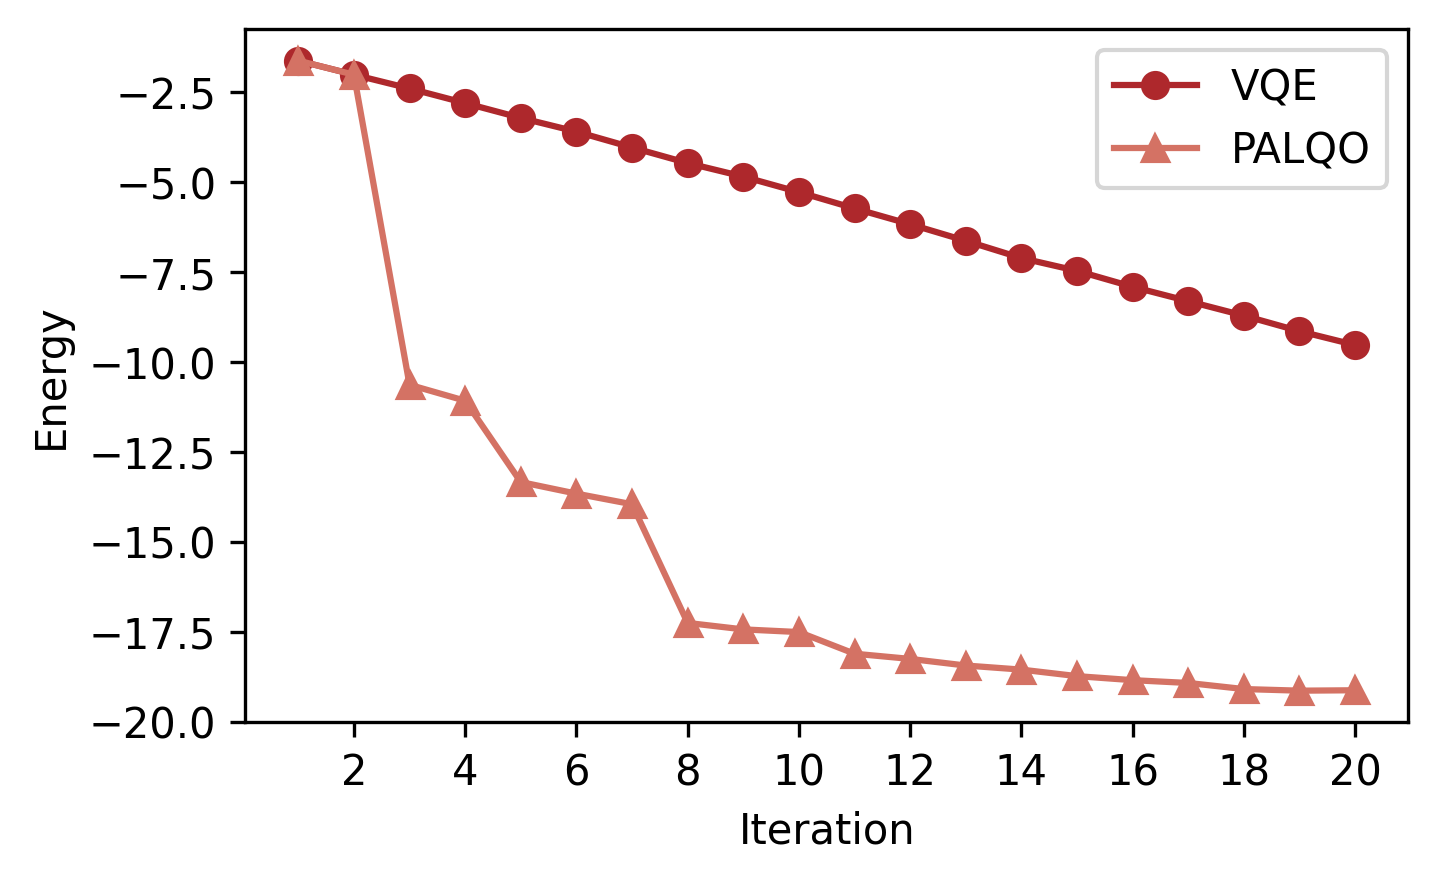

In [12]:
import matplotlib.pyplot as plt

x = range(1, 21) 

# Create the plot
plt.figure(figsize=(5, 3),dpi=300)  # Adjust figure size if needed

plt.plot(x, vqe_energy_history, marker='o', color = '#AE282C', label='VQE')
plt.plot(x, PALQO_energy_list[:20], marker='^', color = '#D47264', label='PALQO')

plt.xlabel('Iteration')  # Or whatever x-axis represents
plt.ylabel('Energy')
xticks_pos = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
plt.xticks(xticks_pos)

plt.legend()
plt.show()